In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from unidecode import unidecode
import glob

In [11]:
# Constantes
CSV_PATH = "../data/dados_emprestimos"
PARQUET_PATH = "../data/dados_exemplares.parquet"
CATEGORIAS = {
    range(0, 100): "GENERALIDADES - CIENCIA E CONHECIMENTO",
    range(100, 200): "FILOSOFIA E PSICOLOGIA",
    range(200, 300): "RELIGIAO",
    range(300, 400): "CIENCIAS SOCIAIS",
    range(400, 500): "CLASSE VAGA, PROVISORIAMENTE NAO OCUPADA",
    range(500, 600): "MATEMATICA E CIENCIAS NATURAIS",
    range(600, 700): "CIENCIAS APLICADAS",
    range(700, 800): "BELAS ARTES",
    range(800, 900): "LINGUAGEM, LINGUA E LINGUISTICA",
    range(900, 1000): "GEOGRAFIA, BIOGRAFIA E HISTORIA",
}

In [12]:
def normalizar_texto(texto):
    """Normaliza strings: remove acentos e converte para maiúsculo."""
    return unidecode(texto).upper()


def carregar_dataframes(caminho):
    """Carrega todos os dataframes de arquivos CSV em um diretório."""
    todos_arquivos = glob.glob(caminho + "/*.csv")
    lista_df = [pd.read_csv(filename, index_col=None, header=0) for filename in todos_arquivos]
    return pd.concat(lista_df, axis=0, ignore_index=True)


def mesclar_dataframes(df1, df2, chave, tipo_mesclagem="inner"):
    """Mescla dois dataframes com base em uma chave comum."""
    return pd.merge(df1, df2, on=chave, how=tipo_mesclagem)


def limpar_dataframe(df):
    """Remove registros com valores nulos e normaliza colunas do tipo string."""
    df = df.dropna()
    df.loc[:, "matricula_ou_siape"] = df["matricula_ou_siape"].astype(int).astype(str)
    df.loc[:, df.select_dtypes(include=["object"]).columns] = df.select_dtypes(include=["object"]).map(normalizar_texto)
    df = df.drop(columns=["registro_sistema"])
    df = df.reset_index(drop=True)
    return df


def mapear_categoria(codigo):
    """Mapeia o código para a categoria correspondente."""
    for chave, valor in CATEGORIAS.items():
        if int(codigo) in chave:
            return valor
    return "CODIGO NAO MAPEADO"


def adicionar_categoria(df):
    """Adiciona a coluna 'categoria' ao dataframe."""
    df["cdu_geral"] = df["localizacao"].apply(mapear_categoria)
    return df

In [14]:
# Carregar os arquivos CSV em um dataframe unificado
df_unificado = carregar_dataframes(CSV_PATH)
# Carregar o arquivo parquet em um dataframe
df_parquet = pd.read_parquet(PARQUET_PATH)
# Mescar os dataframes df_unificado e df_parquet pelo código de barras dos exemplares
df_mesclado = mesclar_dataframes(df_unificado, df_parquet, "codigo_barras")
# Limpar o dataframe mesclado
df_limpo = limpar_dataframe(df_mesclado)
# Adicionar a coluna de categoria ao dataframe
df_final = adicionar_categoria(df_limpo)

C:\Users\laerc\AppData\Local\Temp\ipykernel_14240\1190335303.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['2008112114' '200721119' '2008112114' ... '-2147483648' '-2147483648'
 '-2147483648']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, "matricula_ou_siape"] = df["matricula_ou_siape"].astype(int).astype(str)


In [15]:
emprestimos_data = pd.DataFrame(df_final["data_emprestimo"].value_counts().reset_index())
emprestimos_data.columns = ["data", "quantidade"]
emprestimos_data["data"] = pd.to_datetime(emprestimos_data["data"])

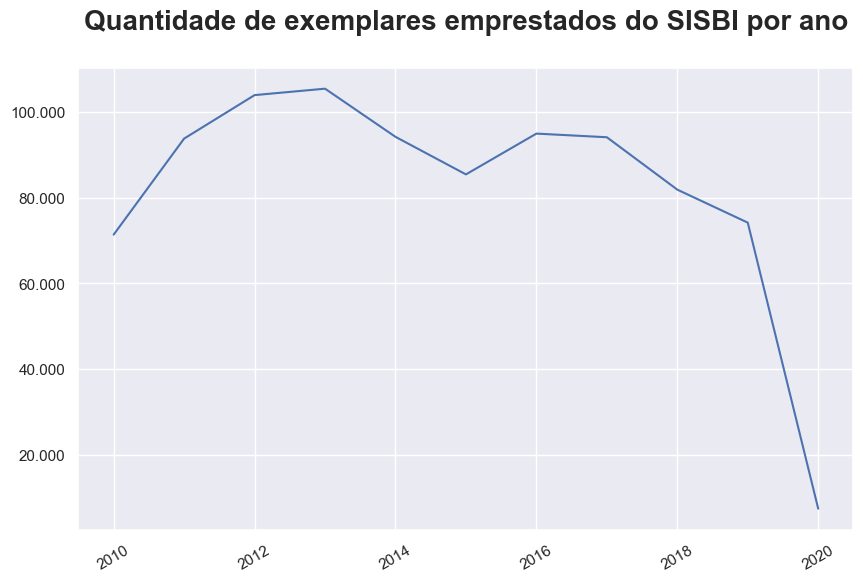

In [16]:
# Configuração global do Seaborn
sns.set_theme(context="notebook", style="darkgrid", palette="deep", font_scale=1, rc={"figure.figsize": (10, 6)})


def plotar_grafico_linhas_total_emprestimos_por_ano(df):
    """Plota um gráfico de linhas com uma linha para cada ano."""
    ax = sns.lineplot(data=df, x="ano", y="quantidade")
    ax.set(xlabel=None, ylabel=None)
    ax.tick_params(axis="x", rotation=30)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: format(int(x), ",").replace(",", ".")))
    ax.set_title("Quantidade de exemplares emprestados do SISBI por ano" + "\n", size=20, loc="center", weight="bold")
    plt.savefig("../images/grafico_emprestimos_por_ano.png")


# Preparação dos dados
emprestimos_por_ano = emprestimos_data.groupby(by=emprestimos_data.data.dt.year)["quantidade"].sum()
emprestimos_por_ano = emprestimos_por_ano.reset_index()
emprestimos_por_ano.columns = ["ano", "quantidade"]

# Plotagem do gráfico
plotar_grafico_linhas_total_emprestimos_por_ano(emprestimos_por_ano)

### Análise do gráfico da quantidade de exemplares emprestados por ano

A análise do gráfico gerado pela função revela uma narrativa detalhada sobre a dinâmica de empréstimos da biblioteca ao longo de uma década, de 2010 a 2020. A trajetória delineada pela linha azul ilustra um crescimento sustentado na quantidade de livros emprestados de 2010 até 2014. Este período de ascensão é seguido por uma fase de estabilidade, com variações modestas, que persiste até 2018.

Contudo, observa-se uma diminuição acentuada após 2018, culminando em um nadir de empréstimos em 2020. Esta retração abrupta pode ser correlacionada a eventos disruptivos externos, notavelmente a pandemia de COVID-19, que impôs restrições operacionais às bibliotecas, limitando o acesso físico ao acervo.

A fase de estabilidade entre 2014 e 2018 pode sugerir um ponto de saturação no engajamento dos usuários ou uma transição nos padrões de empréstimo, talvez impulsionada pela crescente preferência por conteúdos digitais.

É crucial destacar que, apesar da redução drástica em 2020, o volume de empréstimos manteve-se considerável, indicando uma resiliência na demanda por empréstimos, mesmo diante de circunstâncias desafiadoras. O intervalo do eixo Y, oscilando entre 20.000 e 100.000, reforça essa percepção.

A interpretação deste gráfico é instrumental para a biblioteca compreender as flutuações no comportamento de empréstimos ao longo dos anos e desenvolver estratégias focadas no incremento da interação e aproveitamento dos recursos disponibilizados pela instituição.

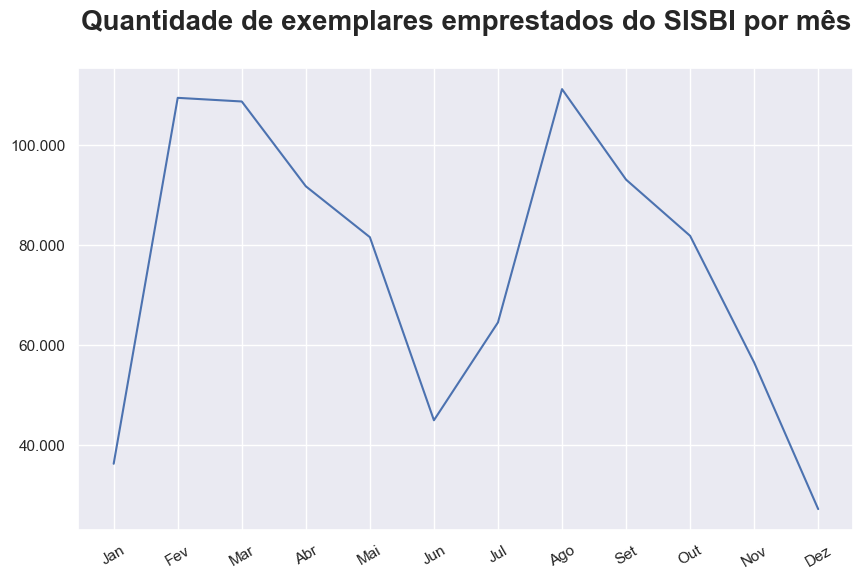

In [17]:
def plotar_grafico_linhas_total_emprestimos_por_mes(df):
    """Plota um gráfico de linhas com uma linha para cada mês."""
    ax = sns.lineplot(data=df, x="mes", y="quantidade")
    ax.set(xlabel=None, ylabel=None)
    ax.tick_params(axis="x", rotation=30)
    # Formatar o eixo x para mostrar todos os meses
    ax.set_xticks(range(1, 13))  # Definir os ticks do eixo x para os meses (1 a 12)
    ax.set_xticklabels(
        ["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Out", "Nov", "Dez"]
    )  # Nomes dos meses

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: format(int(x), ",").replace(",", ".")))
    ax.set_title("Quantidade de exemplares emprestados do SISBI por mês" + "\n", size=20, loc="center", weight="bold")
    plt.savefig("../images/grafico_emprestimos_por_mes.png")


# Preparação dos dados
emprestimos_por_mes = emprestimos_data.groupby(by=emprestimos_data.data.dt.month)["quantidade"].sum()
emprestimos_por_mes = emprestimos_por_mes.reset_index()
emprestimos_por_mes.columns = ["mes", "quantidade"]

# Plotagem do gráfico
plotar_grafico_linhas_total_emprestimos_por_mes(emprestimos_por_mes)

### Análise do gráfico da quantidade de exemplares emprestados por mês

A análise do gráfico gerado revela insights notáveis sobre o padrão de empréstimos ao longo do ano:

- Observa-se uma **tendência decrescente** na quantidade de empréstimos, evidenciada pela linha azul escura, que se estende de **janeiro a dezembro**.
- O ano inicia com uma quantidade **elevada de empréstimos em janeiro**, seguida por uma **ligeira diminuição entre fevereiro e março**, culminando em uma **redução progressiva até junho**.
- Nota-se um **aumento expressivo em julho**, alcançando em **agosto o ápice** de empréstimos do período analisado.

A tendência decrescente pode ser devido a vários fatores, como mudanças sazonais na demanda por empréstimos, alterações no estoque de livros disponíveis, férias letivas, ou até mesmo mudanças nas políticas de empréstimo. 

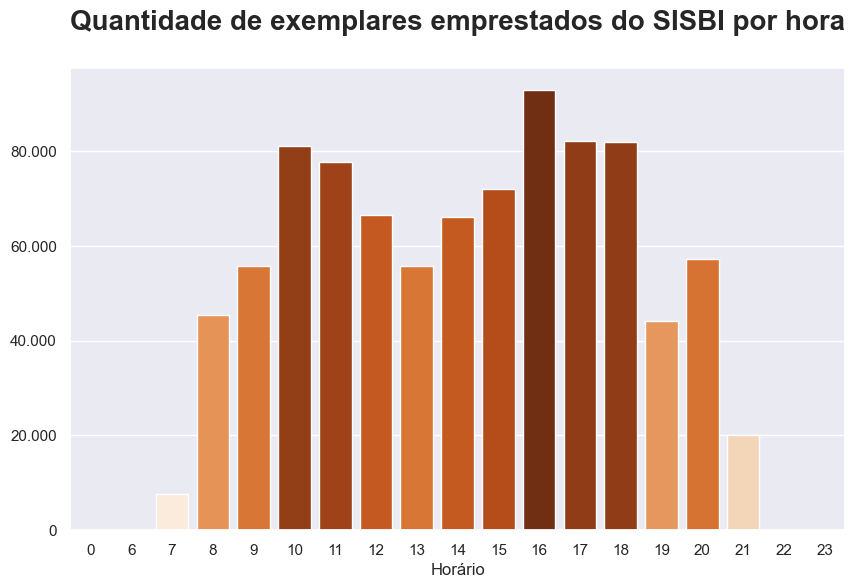

In [18]:
def plotar_grafico_barras_total_emprestimos_por_hora(df):
    """Plota um gráfico de barras com a quantidade de empréstimos por hora."""
    ax = sns.barplot(data=df, x="hora", y="quantidade", palette="Oranges", hue="quantidade", dodge=False)
    plt.legend([], [], frameon=False)  # Excluir a legenda do gráfico

    ax.set(xlabel="Horário", ylabel=None)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: format(int(x), ",").replace(",", ".")))
    ax.set_title("Quantidade de exemplares emprestados do SISBI por hora" + "\n", size=20, loc="center", weight="bold")
    plt.savefig("../images/grafico_emprestimos_por_hora.png")


# Preparação dos dados
emprestimos_por_hora = emprestimos_data.groupby(by=emprestimos_data.data.dt.hour)["quantidade"].sum()
emprestimos_por_hora = emprestimos_por_hora.reset_index()
emprestimos_por_hora.columns = ["hora", "quantidade"]

# Plotagem do gráfico
plotar_grafico_barras_total_emprestimos_por_hora(emprestimos_por_hora)

Analisando o gráfico de barras fornecido, observa-se que a maior atividade de empréstimo ocorre às **18 horas**, com um pico significativo de exemplares emprestados. Outros horários com alta atividade são às **13 e 19 horas**, sugerindo que esses podem ser períodos de intervalo ou término de atividades acadêmicas, quando os usuários aproveitam para pegar ou devolver materiais.

É interessante notar a diminuição nos empréstimos entre as **15 e 17 horas**, o que pode indicar um período menos movimentado na biblioteca, talvez devido a aulas ou outras obrigações dos usuários.

Essas informações podem ser valiosas para a gestão da biblioteca, permitindo ajustar o horário de funcionários, planejar atividades de promoção durante os períodos de menor movimento, e até mesmo considerar a extensão do horário de funcionamento para atender melhor aos picos de demanda. Além disso, estratégias para incentivar o empréstimo durante as horas de menor atividade podem ser exploradas para otimizar o uso do acervo.

In [19]:
df_final["data_emprestimo"] = pd.to_datetime(df_final["data_emprestimo"])


def tabela_frequencia(variavel):
    """Esta função retorna uma tabela de frequência para a variável passada como argumento."""
    contagem = df_final[variavel].value_counts()
    percentuais = round((contagem / contagem.sum()) * 100, 1)
    tabela = pd.DataFrame({"quantidade": contagem, "percentual": percentuais})
    return tabela

In [20]:
# Calcula o percentual de empréstimos por tipo de vínculo de usuário.
tabela_frequencia("tipo_vinculo_usuario")

,quantidade,percentual
tipo_vinculo_usuario,,
ALUNO DE GRADUACAO,724723,80.0
ALUNO DE POS-GRADUACAO,130741,14.4
DOCENTE,26467,2.9
SERVIDOR TECNICO-ADMINISTRATIVO,13558,1.5
ALUNO MEDIO/TECNICO,8192,0.9
DOCENTE EXTERNO,2750,0.3
USUARIO EXTERNO,6,0.0


Analisando a tabela de empréstimos por tipo de vínculo do usuário, percebe-se que os **ALUNOS DE GRADUAÇÃO** representam a maior parte dos empréstimos, com **724723 empréstimos** e **80,0%** do total. Isso destaca o uso intensivo da biblioteca pelos alunos de graduação, que podem estar buscando recursos para seus cursos e pesquisas.

Os **ALUNOS DE PÓS-GRADUAÇÃO** também utilizam a biblioteca significativamente, com **130741 empréstimos**, o que corresponde a **14,4%**. Os **DOCENTES** e **SERVIDORES TÉCNICO-ADMINISTRATIVOS** seguem com **2,9%** e **1,5%** respectivamente, indicando um uso moderado em comparação com os alunos.

Os números caem drasticamente para categorias como **ALUNO MÉDIO/TECNICO**, **DOCENTE EXTERNO**, e **USUÁRIO EXTERNO**, com percentuais abaixo de **1%**, o que pode refletir restrições de acesso ou menor necessidade de recursos da biblioteca.

Esses dados são importantes para entender as necessidades dos diferentes grupos de usuários e podem ajudar a biblioteca a direcionar serviços e recursos de forma mais eficaz. Por exemplo, poderiam ser desenvolvidas estratégias para aumentar o engajamento dos docentes e usuários externos, ou para melhorar o suporte aos alunos de pós-graduação, garantindo que suas necessidades específicas sejam atendidas.

In [21]:
# Calcula o percentual de empréstimos por coleção.
tabela_frequencia("colecao")

,quantidade,percentual
colecao,,
ACERVO CIRCULANTE,905033,99.8
MONOGRAFIAS,560,0.1
PUBLICACOES DE AUTORES DO RN,328,0.0
PUBLICACOES DA UFRN,223,0.0
MULTIMEIOS,72,0.0
OBRAS DE REFERENCIA,60,0.0
DISSERTACOES,50,0.0
FOLHETOS,35,0.0
COLECAO MOSSOROENSE,19,0.0


Analisando a tabela de empréstimos por coleção, é notável que a coleção **ACERVO CIRCULANTE** predomina esmagadoramente com **905033 empréstimos**, o que corresponde a **99,8%** do total. Isso indica que a maior parte dos empréstimos é de itens que estão regularmente em circulação, sugerindo uma alta rotatividade e demanda constante por esses materiais.

As outras coleções, como **MONOGRAFIAS** e **PUBLICACOES DE AUTORES DO RN**, têm números muito menores, com **560** e **328 empréstimos** respectivamente, e percentuais de apenas **0,1%** e **0,0%**. Isso pode refletir uma especialização dessas coleções ou uma demanda mais nichada.

Esses dados podem ser úteis para as bibliotecas ao avaliar quais coleções precisam de mais investimento e quais podem ser melhor promovidas ou expandidas. Estratégias como exposições temáticas ou programas de incentivo à leitura podem ser consideradas para aumentar a utilização das coleções menos emprestadas. Além disso, a análise pode ajudar a identificar tendências de interesse dos usuários e ajustar o acervo de acordo com essas preferências.

In [22]:
# Calcula o percentual de empréstimos por biblioteca.
tabela_frequencia("biblioteca")

,quantidade,percentual
biblioteca,,
BIBLIOTECA CENTRAL ZILA MAMEDE,681642,75.2
BIBLIOTECA SETORIAL DO CENTRO CIENCIAS DA SAUDE - CCS,58392,6.4
BIBLIOTECA SETORIAL PROF. ALBERTO MOREIRA CAMPOS - DEPARTAMENTO DE ODONTOLOGIA,25607,2.8
BIBLIOTECA SETORIAL PROFA. MARIA LUCIA DA COSTA BEZERRA - CERES - CAICO,23257,2.6
BIBLIOTECA SETORIAL DA FACULDADE DE CIENCIAS DA SAUDE DO TRAIRI - FACISA - SANTA CRUZ,22024,2.4
BIBLIOTECA SETORIAL BERTHA CRUZ ENDERS - ESCOLA DE SAUDE DA UFRN - ESUFRN,16570,1.8
"BIBLIOTECA SETORIAL DO CENTRO DE CIENCIAS HUMANAS, LETRAS E ARTES - CCHLA",14257,1.6
BIBLIOTECA SETORIAL PROF. FRANCISCO GURGEL DE AZEVEDO - INSTITUTO QUIMICA - IQ,11358,1.3
BIBLIOTECA SETORIAL PROF. RONALDO XAVIER DE ARRUDA - CCET,8841,1.0


Analisando a tabela de empréstimos por biblioteca, observa-se que a **BIBLIOTECA CENTRAL ZILA MAMEDE** lidera com uma quantidade substancial de **681642 empréstimos**, correspondendo a **75,2%** do total. Isso indica que esta biblioteca é a principal fonte de empréstimos, possivelmente devido à sua coleção abrangente ou localização central.

As outras bibliotecas, como a **BIBLIOTECA SETORIAL DO CENTRO CIENCIAS DA SAUDE - CCS**, têm números significativamente menores, com **58392 empréstimos** e **6,4%** do total. A distribuição mostra uma concentração de empréstimos na biblioteca principal, enquanto as setoriais atendem a uma demanda mais específica ou localizada.

Esses dados podem ser úteis para entender o comportamento dos usuários e alocar recursos de maneira eficiente. Por exemplo, pode-se considerar aumentar o acervo nas bibliotecas setoriais ou melhorar o acesso às coleções da biblioteca central para atender às necessidades dos usuários de forma mais equilibrada. Além disso, estratégias como exposições ou eventos podem ser implementadas para aumentar a visibilidade das bibliotecas com menor percentual de empréstimos.

In [23]:
# Calcula o percentual de empréstimos por CDU geral.
tabela_frequencia("cdu_geral")

,quantidade,percentual
cdu_geral,,
CIENCIAS APLICADAS,637040,70.3
CIENCIAS SOCIAIS,157749,17.4
MATEMATICA E CIENCIAS NATURAIS,27412,3.0
GENERALIDADES - CIENCIA E CONHECIMENTO,25661,2.8
RELIGIAO,25352,2.8
FILOSOFIA E PSICOLOGIA,24568,2.7
"GEOGRAFIA, BIOGRAFIA E HISTORIA",2986,0.3
BELAS ARTES,2851,0.3
"LINGUAGEM, LINGUA E LINGUISTICA",2818,0.3


Analisando a tabela de empréstimos por CDU, é evidente que a categoria **CIENCIAS APLICADAS** domina o cenário, com uma quantidade impressionante de **637040 empréstimos**, o que representa **70,3%** do total. Isso sugere uma forte preferência ou necessidade por materiais relacionados a essa área, talvez devido a cursos populares ou demanda de pesquisa nesse campo.

As **CIENCIAS SOCIAIS** também têm uma presença significativa, com **157749 empréstimos** e **17,4%** do total, indicando um interesse considerável nessa área. No entanto, todas as outras categorias listadas têm uma participação muito menor, variando de **0,3% a 3,0%**, o que pode refletir uma menor quantidade de recursos disponíveis ou uma demanda mais baixa por esses tópicos.

Essa distribuição pode ser útil para bibliotecas e instituições educacionais ao planejar a aquisição de novos materiais, garantindo que as áreas de maior demanda sejam priorizadas. Além disso, pode-se considerar a promoção de categorias menos utilizadas para equilibrar a coleção e incentivar a exploração de novos campos de conhecimento.